# Team segfault

This is an implementation of the scaling/camouflage attack described by Xiao et. al. in their paper, Seeing is Not Believing (2019).



# Strong attack form


The strong attack form (where the attacker specifies both the source and target images) has the following inputs and outputs.

Input:
```
Scaling function  - Scale()
Source image      - src_img
Target image      - tgt_img
Source image size - src_width, src_height
Target image size - tgt_width, tgt_height
```

Output:
```
Attack image      - atk_img
```

The source image is defined as the original image that is to be scaled (input of ```Scale()```). 

The target image is defined as the deceptive image that the attacker wants the output of ```Scale()``` to look like. 

The attack image is the crafted image that is inputted into ```Scale()```.

In non-code cells, the inputs and outputs will be represented as such:

Scaling function - $Scale$ \\
Source Image - $S$ \\
Target image - $T$ \\
Attack image - $A$ 




# Pseudocode
The pseudocode below is for the strong attack form. ```CL, CR, GetCoefficients``` and ```GetPerturbation``` is explained in the next few cells.


## Pseudocode of the image generation

```python
GenerateAttackImage(Scale, src_img, tgt_img)
  m, n   = get_size(src_img)
  m', n' = get_size(tgt_img)

  CL, CR = GetCoefficients(m, n, m', n')

  // perturbation matrix of vertical attack
  delta_v = zeros(m, n')

  // intermediate source image
  src_img* = Scale(src_img)

  for col = 0 to n' - 1:
    // vertical scaling attack
    delta_v[:,col] = GetPerturbation(src_img*[:,col], tgt_img[:,col], CL, obj='min')

  // intermdiate attack image
  atk_img* = unsigned int(src_img* + delta_v)

  // perturbation matrix of horizontal attack
  delta_h = zeros(m, n)

  for row = 0 to m - 1:
    // horizontal scaling attack
    delta_h[row,:] = GetPerturbation(src_img[row,:], atk_img*[row,:], CR, obj='min')

  atk_img = unsigned int(src_img + delta_h)
  return atk_img
```

```zeros(x,y)``` returns a matrix of zeros, size (x,y)

```X[row,:]``` where X is a matrix of size (m,n), returns the specified row of X, a vector sized (1,n)

```X[:,col]``` where X is a matrix of size (m,n), returns the specified column of X, a vector sized (m,1)


# GetCoefficient



## Inner workings of common scaling algorithms
This corresponds to the Recovering Coefficients (5.3) section in the paper.

The notation for matrices used is as follows:

>Matrix $A_{m,n}$ has a size $(m,n)$ \\
Matrix $I_x$ is an identity matrix of size $(x,x)$

It was established that some common scaling algorithms can be represented by the following equation:

>$Scale(X) = CL_{m',m} * X_{m,n} * CR_{n,n'}$

Where $CL$ scales horizontally $(m \rightarrow  m')$ and $CR$ scales vertically $(n \rightarrow n')$ to give an output of size $(m', n')$.


## Finding $CL$ and $CR$
By using the identity matrix, $I_{x}$, the respective $CL$ and $CR$ matrices 
can be found by taking advantage of the fact that they scale horizontally and vertically separately. 

This is done by setting the source image as $I_m * IN_{max}$ and scaling it to an $(m',m)$ size matrix (which negates the need for $CR$ to be applied) to obtain an approximation of $CL$, which is $D/IN_{max}$, where $D$ is the result of the scaling and $IN_{max}$ is the maximum pixel value for the image format (e.g. 255). 

>$CL_{m',m} * (I_m * IN_{max}) = CL_{m',m} * IN_{max}$ \\
$(I_n * IN_{max}) * CR_{n,n'} = CR_{n,n'} * IN_{max}$ \\

Finally, the approximation of $CL$ should be normalised. For each row in $CL$, divide each element by the sum of all elements in the row. The sum of each row should be 1.
>$CL_{m',m(approx)}[i,:] = \frac{CL_{m',m(approx)}[i,:]}{\sum_{j = 0}^{m - 1} (CL_{m',n(approx)}[i,j])}$
 
$X[i,:]$ and $X[:,j]$ refers to the $i$-th row and $j$-th column of matrix $X$ respectively.

#Generating the attack image



## L-Norm
The notation for L-norm used is as follows:

>$\ell_{2}(X)$ is the L2 norm of $X$ \\
$\ell_{\infty}(X)$ is the L-infinity norm of $X$

The L2 norm of a matrix is the square root of the sum of squares of all elements in the matrix. It is also known as the Euclidean norm. This can be described as

>$\ell_{2}(X_{m,n}) = \sqrt{\sum_{i = 1}^{m}\sum_{j = 1}^{n} (X_{ij})^2}$

The L-infinity norm of a matrix is the maximum absolute row sum in the matrix. This means we sum the magnitudes of elements row-wise and take the largest value. This can be described as

>$\ell_{\infty}(X_{m,n}) =  \substack{Max \\1 \le i\le m}[\sum_{j = 1}^{n}(X_{ij})]$

## Perturbation Functions, $\Delta$
The perturbation functions, $\Delta_1$ and $\Delta_2$ (written as `delta` in the code), are the differences between $A$ and $S$ and the final output image ($D$) and $T$ respectively. They are matrices with dimension $(m,n)$ and $(m',n')$, the size of the $S$ and $T$ respectively.

This is described by the following equations
        
>$A$ = $S$ + $\Delta_1$ \\
$D$ = $T$ + $\Delta_2$, where $D$ = $Scale(A)$


The L-infinity norm of $\Delta_2$ has a threshold, given by $\epsilon$ * $IN_{max}$, where $\epsilon$ is the specified contraint.

>$\ell_{\infty}(\Delta_2) \le \epsilon* IN_{max}$

## Scaling Attack in Two Parts
### Image resizing
As pointed out in the paper, due to the nature of the scaling being done in two parts (horizontal, then vertical or vice versa), resizing an image vertically is equivalent to resizing the same image's transpose horizontally. Therefore only one direction of scaling needs to be considered when generating $\Delta_1$ (here, following the paper, vertical scaling is used).

With $S$, $T$ and $CL_{m',m}$ recovered from the previous section, we will create the attack image, $A = S + \Delta_1$.


### Calculation of perturbation matrix
$Scale$ is surjective, meaning for an image $D$ such that $Scale(A) = D$, there are multiple possible $A$ inputs that give the same output $D$. As $A = S + \Delta_1$, $\Delta_1$ needs to be generated and optimised to create the best attack image.

The objective function for the strong attack form is to minimise the square of the L2 norm of $\Delta_1$. We are minimising the sum of squares of each element in the matrix, which represent the difference between the $A$ and $S$. So we are minimising the difference between the images, such that $\ell_{\infty}(\Delta_2)$ stays below the threshold ($\epsilon*IN_{max}$).

Image transformation can be written as:
> $CL_{m',m} * A = [CL*A[:,0]_{(m,1)} \dots CL*A[:,n - 1]_{(m,1)}]$

Therefore, the above can be represented as:

>Objective: 
>>Minimise $(\ell_{2}(\Delta_1[:,j]))^2$

>Subject to:
>> $CL*A[:,j]_{(m,1)} = T[:,j]_{(m',1)} + \Delta_2$ \\
$\ell_{\infty}(\Delta_2) \le \epsilon * IN_{max}$

> $(j = 0, 1, ..., n - 1)$

Image transformation can be written as:


### Optimisation Solution
**Constraints**: Using the natural constraints of each element in the attack image A (pixel values), as mentioned above, each element should be within [0, $IN_{max}$]. Using this, we can get

> $0 \le A[:,j]_{(m,1)} \le IN_{max}$ \\

> $\ell_{\infty}(CL * A[:,j]_{(m,1)} - T[:,j]_{(m',1)}) \le \epsilon*IN_{max}$

**Objective Function**: The objective function is equivalent to

> $min(\Delta_1[:,j]^T*I_m'*\Delta_1[:,j])), (j = 0, 1, ..., n - 1)$

Combining the objective function and constriants gives an $m'$-dimensional quadratic problem with inequality constraints.

**This would be a good time to revisit the pseudocode if it didn't make sense before.**


## Concave-Convex Programming
The strong attack model is a convex optimisation problem, as we are trying to minimise something (objective function) subject to constraints. 

Luckily for us, we have CVXPY and DCCP packages that help with these a ton. 

Some useful things:
```
A = cp.Variable(5) # vector variable of dimension (5,)
M = cp.Variable(5,4) # matrix variable of dimension (5,4)

cp.sum_squares() # equivalent to square of L2 norm

constraints = [] # list of constraints
objective = cp.Minimize(...) # set objective to minimise something
objective = cp.Maximise(...) # set objective to maximise something

prob = cb.Problem(objective, constraints) # solves CCP problem
```
NumPy ndarrays and matrices and SciPy sparse matrices can be used as constants with CVXPY.


# Some actual code now

## Setup
Install `dccp` if not already installed.

In [168]:
# Import statements
! pip install dccp
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cvx
import dccp
import cv2
from google.colab import drive

In [8]:
# Google Drive Mount
drive.mount('/content/drive')

# Change to your own drive's folder
img_folder = '/content/drive/MyDrive/COMP0055/'

Mounted at /content/drive


In [161]:
# Images from github repo
cat = img_folder + 'cat.jpg'
wolf = img_folder + 'wolf.jpg'
sheep = img_folder + 'baa.jpg'

## Scaling Functions

In [12]:
# Resizes using the default resize function for CV2

def resizeCV2(img, height, width):
  dim = (width, height)
  img = cv2.resize(img, dim)
  return img

## Get Coefficients `CL, CR`

In [104]:
def GetCoefficients(Scale, s_m, s_n, t_m, t_n, IN_max):
  '''
    Output:
      CL (m',m)
      CR (n, n') 
  '''
  identity_m = np.identity(s_m)
  identity_n = np.identity(s_n)

  CL = Scale(identity_m * IN_max, t_m, s_m)
  for i in range(0, t_m):
    CL[i,:] = CL[i,:] / CL[i,:].sum()

  CR = Scale(identity_n * IN_max, s_n, t_n)
  for i in range(0, t_n):
    CR[:,i] = CR[:,i] / CR[:,i].sum()

  return CL, CR

## Get Perturbations


In [121]:
def GetPerturbationsCL(src, tgt, CL, e, IN_max):
  in_dim = src.shape[0]
  out_dim = tgt.shape[0]

  delta_1 = cvx.Variable(src.shape)
  atk = cvx.Variable(src.shape)

  objective = cvx.Minimize(cvx.norm(delta_1,2))
  constraints = [
                atk >= 0,
                atk <= IN_max,
                atk == delta_1 + src,
                cvx.norm(CL @ (atk) - tgt, 'inf') <= e * IN_max
  ]

  prob = cvx.Problem(objective, constraints)
  assert dccp.is_dccp(prob)
   
  result = prob.solve(method='dccp', verbose=False)
  delta_1 = np.squeeze(delta_1.value)

  return delta_1

def GetPerturbationsCR(src, tgt, CR, e, IN_max):
  in_dim = src.shape[0]
  out_dim = tgt.shape[0]

  src = src.reshape(1, -1)
  tgt = tgt.reshape(1, -1)

  delta_1 = cvx.Variable(src.shape)
  atk = cvx.Variable(src.shape)

  objective = cvx.Minimize(cvx.norm(delta_1,2))
  constraints = [
                atk >= 0,
                atk <= IN_max,
                atk == delta_1 + src,
                cvx.norm(atk @ CR - tgt, 'inf') <= e * IN_max
  ]

  prob = cvx.Problem(objective, constraints)
  assert dccp.is_dccp(prob)
  
  result = prob.solve(method='dccp', verbose=False)
  delta_1 = np.squeeze(delta_1.value)

  return delta_1

## Main Function


In [165]:
def GenerateAttackImageGrey(Scale, src_img, tgt_img):
  
  #TODO: Try with another solver (solver=cxv.{solver})

  # Specify image factor
  IN_max = 255

  # Get dimensions of source and target images
  s_m, s_n = src_img.shape # m,n
  t_m, t_n = tgt_img.shape # m',n'

  # Returns approximations of scaling matrices
  CL, CR = GetCoefficients(Scale,s_m, s_n, t_m, t_n, IN_max)

  # Column-wise scaled to target image
  # Intermediate source image
  int_src_img = Scale(src_img, s_m, t_n)
  # Perturbation matrix of vertical attack
  
  # delta_v = np.zeros(src_img.shape)
  delta_v = np.zeros((s_m, t_n))#, dtype=np.uintc)

  for col in range(0, t_n):
    delta_v[:,col] = GetPerturbationsCL(int_src_img[:,col], tgt_img[:,col], CL, 0.01, IN_max)
  
  int_atk_img = int_src_img + delta_v

  delta_h = np.zeros((src_img.shape))#, dtype=np.uintc)
  
  for row in range(0, s_m):
    delta_h[row,:] = GetPerturbationsCR(src_img[row,:], int_atk_img[row,:], CR, 0.01, IN_max)

  atk_img = src_img + delta_h
  return atk_img

/usr/local/lib/python3.6/dist-packages/cvxpy/problems/problem.py:1126: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


In [ ]:
# Generate attack image

src = cv2.imread(sheep, 0)
tgt = cv2.imread(wolf, 0)
a,b = tgt.shape
atk_img = GenerateAttackImageGrey(resizeCV2, src, tgt)

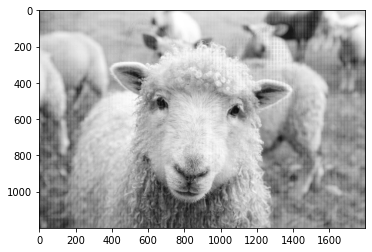

In [166]:
# Show attack image

plt.imshow(atk_img, cmap='gray', vmin=0, vmax=255)

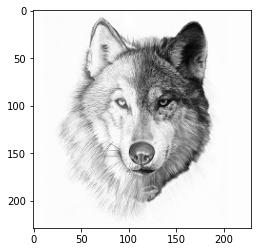

In [170]:
# Show scaled attack image

plt.imshow(resizeCV2(atk_img, a, b), cmap='gray', vmin=0, vmax=255)

In [162]:
# Save attack image (local)

plt.imsave('atk_img.jpg', atk_img, cmap='gray')

/usr/local/lib/python3.6/dist-packages/cvxpy/problems/problem.py:1126: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


#References


https://stackoverflow.com/questions/63519965/torch-transform-resize-vs-cv2-resize
https://pytorch.org/docs/stable/generated/torch.transpose.html
https://stackoverflow.com/questions/29241056/how-does-numpy-newaxis-work-and-when-to-use-it
https://docs.opencv.org/master/d3/df2/tutorial_py_basic_ops.html
https://www.cvxpy.org/tutorial/intro/index.html
https://github.com/cvxgrp/dccp
https://web.stanford.edu/~boyd/papers/pdf/dccp.pdf
https://docs.opencv.org/3.4/d8/d6a/group__imgcodecs__flags.html
https://arxiv.org/pdf/1604.02639.pdf
